In [14]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D #for convolutional and max pooling layers
from keras.layers import Flatten #collapse multi-d arrays to 1D

## Dataset overview (MNIST)

This notebook trains a convolutional neural network on **MNIST**, a standard handwritten digit dataset.

Each example is a small image of a single digit **0–9**:
- **28 × 28** pixels
- **grayscale** (one intensity value per pixel)
- pixel values represent **how dark the ink is** at each location (black/white intensity)

In code, the data is stored as numbers because an image is just a grid of pixel intensities.
When you call `plt.imshow(...)`, matplotlib turns that numeric grid into an image you can see.


## Why the images look like “number data”

An image is a matrix (grid) of numbers.

For MNIST:
- each pixel is one number
- larger numbers usually mean a “brighter” pixel (or darker, depending on the colormap)
- the model learns patterns in these numbers (edges, curves, strokes) that correspond to digits

If your data is normalized, pixel values are often in **[0, 1]** instead of **[0, 255]**.


In [17]:
(X_train, y_train), (X_valid, y_valid) = mnist.load_data()

X_train shape: (60000, 28, 28) dtype: uint8
y_train shape: (60000,) dtype: uint8
X_valid shape: (10000, 28, 28) dtype: uint8
y_valid shape: (10000,) dtype: uint8
X_train min/max: 0 255


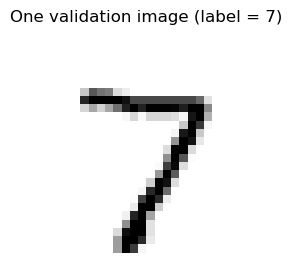

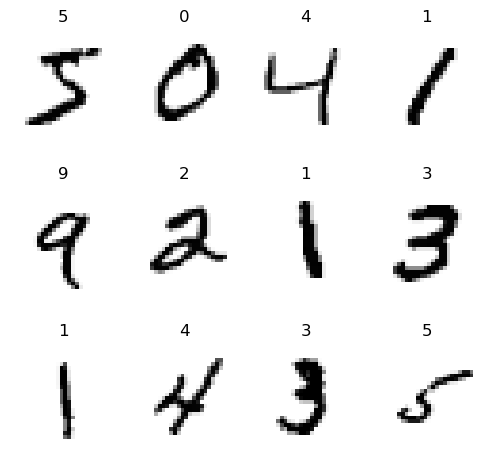

In [18]:
# Visualize what the data looks like and confirm shapes / ranges
import numpy as np
import matplotlib.pyplot as plt

print("X_train shape:", X_train.shape, "dtype:", X_train.dtype)
print("y_train shape:", y_train.shape, "dtype:", y_train.dtype)
print("X_valid shape:", X_valid.shape, "dtype:", X_valid.dtype)
print("y_valid shape:", y_valid.shape, "dtype:", y_valid.dtype)

# Pixel range is often 0..255 before normalization, then 0..1 after normalization
print("X_train min/max:", np.min(X_train), np.max(X_train))

# Show one image (index 0)
plt.figure(figsize=(3,3))
plt.imshow(X_valid[0].squeeze(), cmap='Greys')  # squeeze handles (28,28,1) cleanly
plt.title(f"One validation image (label = {y_valid[0]})")
plt.axis('off')
plt.show()

# Show a small grid of training images
plt.figure(figsize=(5,5))
for k in range(12):
    plt.subplot(3, 4, k+1)
    plt.imshow(X_train[k].squeeze(), cmap='Greys')
    plt.title(str(y_train[k]))
    plt.axis('off')
plt.tight_layout()
plt.show()


### Retaining 2D image shape

In [20]:
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32')
X_valid = X_valid.reshape(10000, 28, 28, 1).astype('float32')

In [21]:
X_train /= 255
X_valid /= 255

In [22]:
n_classes = 10
y_train = keras.utils.to_categorical(y_train, n_classes)
y_valid = keras.utils.to_categorical(y_valid, n_classes)

### Convolution Neural Network model inpsired by LeNet-5

In [ ]:
model = Sequential()

#first conv layer
model.add(Conv2D(32, kernel_size=(3,3), activation='relu',
                 input_shape=(28,28,1)))

#second conv layer, with pooling and dropout
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) #25 percent of neurons randomly withheld each epoch
model.add(Flatten())

#dense hidden layer, with dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

#output layer
model.add(Dense(n_classes, activation='softmax'))

## Model architecture

This model is a convolutional neural network (`CNN`) designed to classify handwritten digit images from the `MNIST` dataset. It takes `28 × 28` grayscale images as input and learns increasingly abstract visual features as data flows through the network.

### Convolutional feature extraction

The first two layers are `Conv2D` layers that apply small `3 × 3` learnable filters across the image.

Each filter slides **left to right and top to bottom** over the image, computing local dot products at each position. This scanning process allows the network to detect spatial patterns regardless of where they appear.

- The first convolutional layer learns low level features such as `edges` and `simple strokes`.
- The second convolutional layer increases the number of filters, allowing the model to capture more complex patterns formed from combinations of earlier features.

Both layers use the `ReLU` (Rectified Linear Unit) activation function. `ReLU` outputs `0` for negative values and leaves positive values unchanged, introducing nonlinearity while helping the network train efficiently.

### Pooling and regularization

- `MaxPooling2D (2 × 2)` reduces the spatial dimensions of the feature maps while preserving the strongest activations.
- `Dropout (25%)` randomly disables a fraction of neurons during training to reduce `overfitting`.

### Fully connected classification

- `Flatten` converts the 2D feature maps into a 1D vector.
- A `Dense` hidden layer with `128` neurons learns high-level combinations of the extracted features.
- `Dropout (50%)` provides additional regularization before classification.

### Output layer

The final `Dense` layer uses `softmax` activation to convert the model’s outputs into class probabilities. Each value represents the predicted probability of a digit class, and all probabilities sum to `1`.


In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

## Reading `model.summary()`: shapes and parameter counts

This section explains how the output shapes and parameter totals shown in `model.summary()` are computed.

### Output shapes

- `Conv2D (32 filters, 3×3)`  
  `28×28×1 → 26×26×32`  
  With valid padding and stride 1, each spatial dimension shrinks by 2. The depth equals the number of filters.

- `Conv2D (64 filters, 3×3)`  
  `26×26×32 → 24×24×64`  
  The spatial size again shrinks by 2, while the depth increases to 64.

- `MaxPooling2D (2×2)`  
  `24×24×64 → 12×12×64`  
  Pooling halves height and width while preserving the number of channels.

- `Flatten`  
  `12×12×64 → 9216`  
  The 3D activation map is reshaped into a 1D vector.

- `Dense (128)`  
  `9216 → 128`

- `Dense (10)`  
  `128 → 10`

### Parameter calculations

- First convolutional layer: `320` parameters  
  `(3 × 3 × 1) × 32 + 32`  
  Each filter has one bias term.

- Second convolutional layer: `18,496` parameters  
  `(3 × 3 × 32) × 64 + 64`

- Dense hidden layer: `1,179,776` parameters  
  `9216 × 128 + 128`

- Output layer: `1,290` parameters  
  `128 × 10 + 10`

This breakdown shows why most parameters in CNNs typically come from the fully connected layers rather than the convolutional layers.


### Configure Model

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Model compilation

The model is compiled by specifying the loss function, optimizer, and evaluation metric. These choices define how the network learns and how performance is monitored during training.

### Loss: `categorical_crossentropy`

`categorical_crossentropy` measures the difference between the predicted class probability distribution and the true label. It is used for multi-class classification problems where exactly one class is correct and labels are one-hot encoded. The loss penalizes low probability assigned to the correct class, with larger penalties when the model is confident but wrong. Lower values indicate predictions that are closer to the true labels.

### Optimizer: `adam`

`Adam` controls how model weights are updated during training. It combines adaptive learning rates with momentum. Momentum uses a running average of past gradients to smooth updates and reduce oscillations, while adaptive learning rates adjust step sizes for each parameter based on gradient magnitude and variability. Together, these properties lead to faster and more stable convergence.

### Metric: `accuracy`

`Accuracy` measures the proportion of correctly classified inputs. The predicted class is chosen as the one with the highest probability and compared to the true label. Accuracy is used only for monitoring performance and does not affect weight updates, since it does not provide gradient information.


### Model Training

In [32]:
model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_valid, y_valid))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - accuracy: 0.9288 - loss: 0.2337 - val_accuracy: 0.9832 - val_loss: 0.0532
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 101ms/step - accuracy: 0.9747 - loss: 0.0833 - val_accuracy: 0.9864 - val_loss: 0.0408
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step - accuracy: 0.9808 - loss: 0.0636 - val_accuracy: 0.9879 - val_loss: 0.0377
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - accuracy: 0.9846 - loss: 0.0511 - val_accuracy: 0.9889 - val_loss: 0.0326
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 99ms/step - accuracy: 0.9862 - loss: 0.0441 - val_accuracy: 0.9915 - val_loss: 0.0277
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 102ms/step - accuracy: 0.9871 - loss: 0.0408 - val_accuracy: 0.9905 - val_loss: 0.0292
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - accuracy: 0.9894 - loss: 0.0341 - val_accuracy: 0.9909 - val_loss: 0.0278
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - accuracy: 0.9906 - loss: 0.

## Final model performance

The model achieves very strong performance on the `MNIST` digit classification task.

Training accuracy of `0.9918` indicates that approximately `99.18 percent` of the training images are classified correctly. The low training loss of `0.0254` shows that the model’s predicted probability distributions closely match the true digit labels.

Validation accuracy of `0.9910` demonstrates that the model generalizes well to unseen data. The validation loss of `0.0316` is slightly higher than the training loss, which is expected and suggests effective regularization rather than overfitting.

The close agreement between training and validation accuracy indicates that the model is not memorizing the training data and is learning robust features for handwritten digit recognition. Overall, this convolutional neural network performs very well on `MNIST` and achieves accuracy that is comparable to well established approaches for this task.
